In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms,models
import pandas as pd
from PIL import Image
import itertools
from IPython.display import display
import os
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pd.set_option('display.max_rows', 301)

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


Tesla P100-PCIE-16GB


In [3]:
#For plotting confusion matrix in kaggle kernel 
#Credit: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Handling Image Input from Dataset
### Performing Operations: Dataload,Transform,Split, Compose(Normalize,Resize,Random-Flip,Crop etc.)

In [4]:
train_transform = transforms.Compose([
   transforms.RandomRotation(10),
   transforms.RandomHorizontalFlip(), #default probabily
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])                            
])

test_transform = transforms.Compose([
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485,0.456,0.406], 
                        [0.229,0.224,0.225])                                 
])

In [5]:
root = '../input/fire-smoke-and-neutral/FIRE-SMOKE-DATASET/'
#Using image folder (0f torchvision)
train_data = datasets.ImageFolder(os.path.join(root,'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'Test'), transform=test_transform)

torch.manual_seed(42)

#data loader
train_loader = DataLoader(train_data, batch_size=10, shuffle= True)
test_loader = DataLoader(test_data, batch_size=10,shuffle= True)


class_names = train_data.classes
print(class_names)

['Fire', 'Neutral', 'Smoke']


#### C.Name   -   Index
#### Fire    -->   0
#### Neutral -->   1
#### Smoke   -->   2

In [6]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 2700
Test data size: 300


In [7]:
for images, labels in train_loader:
      break

In [8]:
images.shape 
#output (#images per batch, #channels, dimensions)

torch.Size([10, 3, 224, 224])

In [9]:
#For viewing original image on plt.imshow
#Denormalized
#to understand how normalization applied
inverse_normalized = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225], 
                                      std=[1/0.229,1/0.224,1/0.225])
# image_inv = inverse_normalized(NORMALIZED_IMAGE)
# plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

Label: [2 0 0 2 1 2 1 1 2 1]
Class: Smoke Fire Fire Smoke Neutral Smoke Neutral Neutral Smoke Neutral


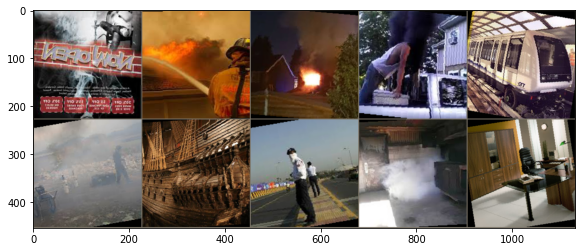

In [10]:
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow = 5)
inv_normalized = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225], 
                                      std=[1/0.229,1/0.224,1/0.225])
im_inv = inv_normalized(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [11]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # In Channels -> 3 
        # Out channels -> 6
        # Filter -> 3x3
        # Stride -> 1
        self.conv1 = nn.Conv2d(3,6,3,1)

        # In Channels -> 6 
        # Out channels -> 16
        # Filter -> 3x3
        # Stride -> 1
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        # **Adding another convulotional layer**
        # In Channels -> 16
        # Out channels -> 26
        # Filter -> 3x3
        # Stride -> 1
        self.conv3 = nn.Conv2d(16,26,3,1)
        
        # **Adding another convulotional layer**
        # In Channels -> 26
        # Out channels -> 36
        # Filter -> 3x3
        # Stride -> 1
        self.conv4 = nn.Conv2d(26,36,3,1)
        
        
        # **Adding another convulotional layer**
        # In Channels -> 36
        # Out channels -> 
        # Filter -> 3x3
        # Stride -> 1
        self.conv5 = nn.Conv2d(36,48,3,1)

        
    # input calculation -> Floor(((((((((224-2)/2)-2)/2)-2)/2)-2)/2)-2)/2  = 5 
    #(-2 for each filter with no padding)
    # (/2 for each pooling)
        self.fc1 = nn.Linear(5*5*48,512) 
        self.fc2 = nn.Linear(512,256) 
        self.fc3 = nn.Linear(256,80)
        self.fc4 = nn.Linear(80,3)
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

        X = X.view(-1, 5*5*48)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)

        return F.log_softmax(X, dim=1)

In [12]:
#Hyper parameters
SEED = 101
LEARNING_RATE = 0.001
EPOCHS = 9
MAX_BATCH_SIZE = 9999999 #unlimited (whole dataset)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

#CNN Model
modelCNN = ConvNetwork()
modelCNN = modelCNN.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr= LEARNING_RATE)

In [13]:
modelCNN

ConvNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 26, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(26, 36, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=3, bias=True)
)

In [14]:
total_params = 0
for parameters in modelCNN.parameters():
    total_params += parameters.numel()
print(f"Total params: {total_params} ")

Total params: 795921 


In [15]:
start_time = time.time()

#Limiting batch sizes
max_trn_batch = MAX_BATCH_SIZE #1800 
max_tst_batch = MAX_BATCH_SIZE #300 

train_losses = []
test_losses = []
train_correct = []
test_correct = []


for i in range(EPOCHS):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        #Limiting batch sizes for testing the model (if required)
        if b==max_trn_batch:
            break     
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        b+=1
        y_pred = modelCNN(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing correct predictions (training)
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%70 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} Training accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
      
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            if( b==max_tst_batch):
                break
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelCNN(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {(total_time/60):.2f} mins')

Epoch:1 Batch:70 Loss:0.8198096 Training accuracy: 50.714% 
Epoch:1 Batch:140 Loss:0.7222495 Training accuracy: 54.714% 
Epoch:1 Batch:210 Loss:0.7288984 Training accuracy: 56.238% 
Epoch:2 Batch:70 Loss:0.7115662 Training accuracy: 60.286% 
Epoch:2 Batch:140 Loss:0.5829678 Training accuracy: 61.500% 
Epoch:2 Batch:210 Loss:0.6249727 Training accuracy: 61.714% 
Epoch:3 Batch:70 Loss:1.2418188 Training accuracy: 62.429% 
Epoch:3 Batch:140 Loss:0.4133288 Training accuracy: 63.071% 
Epoch:3 Batch:210 Loss:0.6677977 Training accuracy: 61.714% 
Epoch:4 Batch:70 Loss:0.5196413 Training accuracy: 67.000% 
Epoch:4 Batch:140 Loss:0.5505515 Training accuracy: 66.071% 
Epoch:4 Batch:210 Loss:0.3066382 Training accuracy: 68.952% 
Epoch:5 Batch:70 Loss:0.3727171 Training accuracy: 81.143% 
Epoch:5 Batch:140 Loss:0.3398547 Training accuracy: 81.929% 
Epoch:5 Batch:210 Loss:0.2326334 Training accuracy: 81.476% 
Epoch:6 Batch:70 Loss:0.5033203 Training accuracy: 81.857% 
Epoch:6 Batch:140 Loss:0.53862

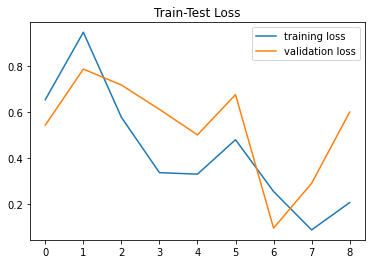

In [16]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

In [ ]:
plt.plot([t/270 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch (CNN)')
plt.legend();

In [17]:
print(test_correct)
test_data_size = len(test_data)
print(f'Test accuracy: {test_correct[-1].item()*100/test_data_size:.2f}%')

[tensor(179, device='cuda:0'), tensor(185, device='cuda:0'), tensor(169, device='cuda:0'), tensor(218, device='cuda:0'), tensor(234, device='cuda:0'), tensor(243, device='cuda:0'), tensor(230, device='cuda:0'), tensor(237, device='cuda:0'), tensor(251, device='cuda:0')]
Test accuracy: 83.67%


In [18]:
for i,acc in enumerate(test_correct):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/test_data_size:.2f}%')

Test accuracy for ephoch-1: 59.67%
Test accuracy for ephoch-2: 61.67%
Test accuracy for ephoch-3: 56.33%
Test accuracy for ephoch-4: 72.67%
Test accuracy for ephoch-5: 78.00%
Test accuracy for ephoch-6: 81.00%
Test accuracy for ephoch-7: 76.67%
Test accuracy for ephoch-8: 79.00%
Test accuracy for ephoch-9: 83.67%


In [19]:
# Manual evaluation on test set
modelCNN.eval()
corr_pred = 0
act = []
pred = []

for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelCNN(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(class_names[labs[i].item()])
        pred.append(class_names[new_pred.item()])
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (CNN): {corr_pred} ")
print(f"\nTest Set Accuracy (CNN): {100*corr_pred/len(test_data):.2f}% ")


Correctly Predicted (CNN): 251 

Test Set Accuracy (CNN): 83.67% 


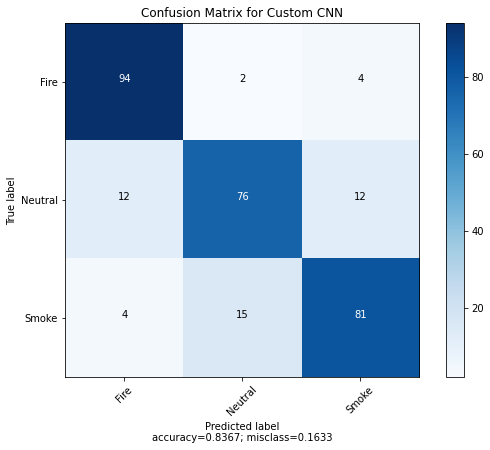

In [20]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for Custom CNN")

In [21]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
# print(f"Recall (CNN): {recall}")
# print(f"Precision (CNN): {precision}")
evalDict = {}
evalDict['Class Name'] = class_names
evalDict['Recall'] = recall
evalDict['Precision'] = precision
evalDf = pd.DataFrame(evalDict)
evalDf

,Class Name,Recall,Precision
0,Fire,0.94,0.854545
1,Neutral,0.76,0.817204
2,Smoke,0.81,0.835052


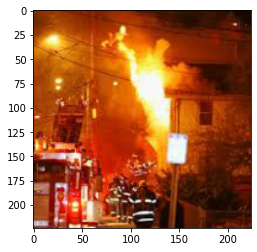

In [22]:
#Testing a single image
img_index = 50
#test data already transformed and normalized (denormalized to view them in plt.imshow)
im_test = inverse_normalized(test_data[img_index][0]) 
plt.imshow(np.transpose(im_test.numpy(), (1,2,0)))

In [23]:
# Evaluating model with a single image from dataset
modelCNN.eval() 

with torch.no_grad():
    new_pred = modelCNN(test_data[img_index][0].view(1,3,224,224).cuda()).argmax()

print(f'Predicted class: {class_names[new_pred.item()]}')

Predicted class: Fire


# Pre-trained Models
#### 1. **Alexnet**
#### 2. **Resnet**
#### 3. **VGG-16**
#### 4. **ZFNET**
#### 5. **GoogLeNet**

## 1. Alexnet

In [24]:
modelAlexnet = models.alexnet(pretrained=True)
#Freezing pretrained parameters (w,b)

for param in modelAlexnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [25]:
#Hyperparams
ALEXLR = 0.001
ALEXEPOCH = 4
ALEXSEED = 42
ALEXDROPOUT  = 0.5
ALEX_MAX_BATCH_SIZE = 99999999
torch.manual_seed(ALEXSEED)
torch.cuda.manual_seed(ALEXSEED)

#Modifying the classicification section 
modelAlexnet.classifier = nn.Sequential(nn.Linear(9216,1024),
                                       nn.ReLU(),
                                       nn.Dropout(ALEXDROPOUT),
                                       nn.Linear(1024,512),
                                       nn.ReLU(),
                                       nn.Linear(512,256),
                                       nn.ReLU(),
                                       nn.Linear(256,3),
                                       nn.LogSoftmax(dim=1))

modelAlexnet = modelAlexnet.cuda()

In [26]:
modelAlexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [27]:
total_params = 0
for parameters in modelAlexnet.parameters():
    print(parameters.numel())
    total_params += parameters.numel()
print(f"Total params (alexnet): {total_params/1000000} mil")

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
524288
512
131072
256
768
3
Total params (alexnet): 12.564803 mil


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelAlexnet.classifier.parameters(), lr=ALEXLR)

In [29]:
modelAlexnet.train()
start_time = time.time()

#Limiting batch sizes
max_trn_batch = ALEX_MAX_BATCH_SIZE #600 
max_tst_batch = ALEX_MAX_BATCH_SIZE #200 

# Tracking losses
train_losses_anet = []
test_losses_anet = []
train_correct_anet = []
test_correct_anet = []


for i in range(ALEXEPOCH):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
            
          #Limiting batch sizes for testing the model
        if b==max_trn_batch:
            break

        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        b+=1
        y_pred = modelAlexnet(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing #correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%10 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
      
    train_losses_anet.append(loss)
    train_correct_anet.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            if( b==max_tst_batch):
                break
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelAlexnet(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses_anet.append(loss)
    test_correct_anet.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

Epoch:1 Batch:10 Loss:1.6758741 accuracy: 45.000% 
Epoch:1 Batch:20 Loss:0.4021888 accuracy: 58.000% 
Epoch:1 Batch:30 Loss:0.3490019 accuracy: 69.000% 
Epoch:1 Batch:40 Loss:0.4703668 accuracy: 72.500% 
Epoch:1 Batch:50 Loss:0.0776191 accuracy: 74.200% 
Epoch:1 Batch:60 Loss:0.3829733 accuracy: 77.000% 
Epoch:1 Batch:70 Loss:0.5196182 accuracy: 78.714% 
Epoch:1 Batch:80 Loss:0.1708303 accuracy: 79.500% 
Epoch:1 Batch:90 Loss:0.0246635 accuracy: 80.889% 
Epoch:1 Batch:100 Loss:0.9786445 accuracy: 81.200% 
Epoch:1 Batch:110 Loss:0.2541660 accuracy: 82.000% 
Epoch:1 Batch:120 Loss:0.0432103 accuracy: 82.667% 
Epoch:1 Batch:130 Loss:0.0472782 accuracy: 83.154% 
Epoch:1 Batch:140 Loss:0.2980379 accuracy: 83.429% 
Epoch:1 Batch:150 Loss:0.1620296 accuracy: 83.667% 
Epoch:1 Batch:160 Loss:0.2558047 accuracy: 83.875% 
Epoch:1 Batch:170 Loss:0.0735664 accuracy: 84.471% 
Epoch:1 Batch:180 Loss:0.3048133 accuracy: 84.778% 
Epoch:1 Batch:190 Loss:0.4283662 accuracy: 84.842% 
Epoch:1 Batch:200 Los

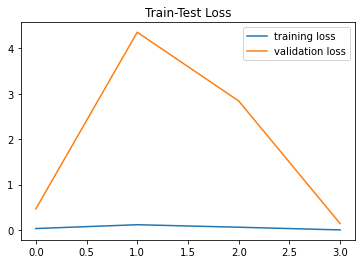

In [30]:
plt.plot(train_losses_anet, label='training loss')
plt.plot(test_losses_anet, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

In [ ]:
plt.plot([t/270 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch (ALEXNET)')
plt.legend();

In [31]:
print(test_correct_anet)
test_data_size = len(test_data)
print(f'Test accuracy: {test_correct_anet[-1].item()*100/test_data_size:.2f}%')

[tensor(259, device='cuda:0'), tensor(245, device='cuda:0'), tensor(257, device='cuda:0'), tensor(271, device='cuda:0')]
Test accuracy: 90.33%


In [32]:
for i,acc in enumerate(test_correct_anet):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/test_data_size:.2f}%')

Test accuracy for ephoch-1: 86.33%
Test accuracy for ephoch-2: 81.67%
Test accuracy for ephoch-3: 85.67%
Test accuracy for ephoch-4: 90.33%


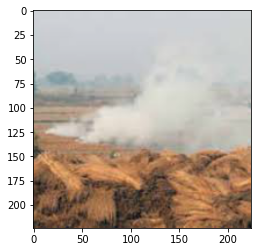

In [33]:
#Testing a single image
img_index = 73
#test data already transformed and normalized (denormalized to view them in plt.imshow)
im_test = inverse_normalized(test_data[img_index][0]) 
plt.imshow(np.transpose(im_test.numpy(), (1,2,0)))

In [34]:
# Evaluating model with a single image from dataset
modelAlexnet.eval() 

with torch.no_grad():
    new_pred = modelAlexnet(test_data[img_index][0].view(1,3,224,224).cuda()).argmax()

print(f'Predicted class: {class_names[new_pred.item()]}')

Predicted class: Smoke


In [35]:
# Manual evaluation on test set
modelAlexnet.eval()
corr_pred = 0
act = []
pred = []

for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelAlexnet(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(class_names[labs[i].item()])
        pred.append(class_names[new_pred.item()])
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (ALEXNET): {corr_pred} ")
print(f"\nTest Set Accuracy (ALEXNET): {100*corr_pred/len(test_data):.2f}% ")

#Print as dataframe
# evalDict = {}
# evalDict['Actual'] = act
# evalDict['Predicted'] = pred
# evalDf = pd.DataFrame(evalDict)
# #evalDf.head(300)


Correctly Predicted (ALEXNET): 272 

Test Set Accuracy (ALEXNET): 90.67% 


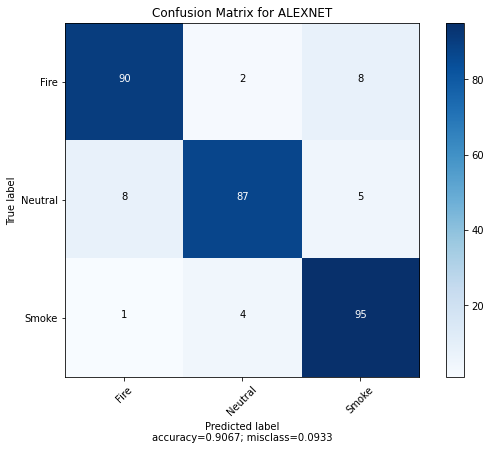

In [36]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for ALEXNET")

In [37]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
evalDict = {}
evalDict['Class Name'] = class_names
evalDict['Recall'] = recall
evalDict['Precision'] = precision
evalDf = pd.DataFrame(evalDict)
evalDf

,Class Name,Recall,Precision
0,Fire,0.90,0.909091
1,Neutral,0.87,0.935484
2,Smoke,0.95,0.879630


# 2. Resnet


In [38]:
modelResnet = models.resnet18(pretrained=True)

for param in modelResnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [39]:
default_infeatures = modelResnet.fc.in_features
modelResnet.fc = nn.Linear(default_infeatures, len(class_names))
modelResnet.fc

Linear(in_features=512, out_features=3, bias=True)

In [40]:
total_params = 0
for parameters in modelResnet.parameters():
  #print(parameters.numel())
  total_params += parameters.numel()
print(f"Total params (alexnet): {total_params/1000000} mil")

Total params (alexnet): 11.178051 mil


In [41]:
modelResnet = modelResnet.to(device)

In [42]:
#Hyper parameters
resLR = 0.001
resMomentum = 0.9
resStepSize = 5
resGamma = 0.1
resEPOCH = 9
RESSEED = 101

torch.manual_seed(RESSEED)
torch.cuda.manual_seed(RESSEED)

criterion = nn.CrossEntropyLoss()
#SGD as optimizer with lr and momentum
optimizer = torch.optim.SGD(modelResnet.fc.parameters(), lr= resLR, momentum= resMomentum)
# Exponential learning rate
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = resStepSize, gamma = resGamma)

In [43]:
modelResnet.train()

start_time = time.time()

# Tracking losses
train_losses_resnet = []
test_losses_resnet = []
train_correct_resnet = []
test_correct_resnet = []


for i in range(resEPOCH):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
            
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        b+=1
        y_pred = modelResnet(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing #correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%70 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
    
    exp_lr_scheduler.step() 
    train_losses_resnet.append(loss)
    train_correct_resnet.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelResnet(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses_resnet.append(loss)
    test_correct_resnet.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

Epoch:1 Batch:70 Loss:0.4869907 accuracy: 71.571% 
Epoch:1 Batch:140 Loss:0.1060030 accuracy: 77.071% 
Epoch:1 Batch:210 Loss:0.4549006 accuracy: 80.571% 
Epoch:2 Batch:70 Loss:0.2213136 accuracy: 86.429% 
Epoch:2 Batch:140 Loss:0.5764418 accuracy: 87.786% 
Epoch:2 Batch:210 Loss:0.2497902 accuracy: 88.952% 
Epoch:3 Batch:70 Loss:0.2961836 accuracy: 90.000% 
Epoch:3 Batch:140 Loss:0.2233066 accuracy: 88.929% 
Epoch:3 Batch:210 Loss:0.3898513 accuracy: 89.190% 
Epoch:4 Batch:70 Loss:0.3869904 accuracy: 88.000% 
Epoch:4 Batch:140 Loss:0.3319985 accuracy: 88.143% 
Epoch:4 Batch:210 Loss:0.2066906 accuracy: 88.571% 
Epoch:5 Batch:70 Loss:0.0491584 accuracy: 90.143% 
Epoch:5 Batch:140 Loss:0.1404157 accuracy: 89.071% 
Epoch:5 Batch:210 Loss:0.2500849 accuracy: 89.619% 
Epoch:6 Batch:70 Loss:0.2613210 accuracy: 90.714% 
Epoch:6 Batch:140 Loss:0.2617232 accuracy: 91.571% 
Epoch:6 Batch:210 Loss:0.7547210 accuracy: 91.238% 
Epoch:7 Batch:70 Loss:0.4682781 accuracy: 90.857% 
Epoch:7 Batch:140 L

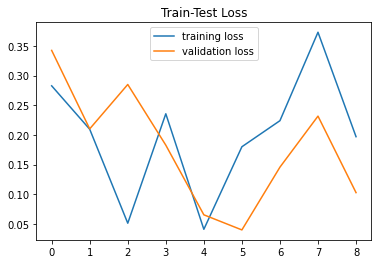

In [44]:
plt.plot(train_losses_resnet, label='training loss')
plt.plot(test_losses_resnet, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

In [ ]:
plt.plot([t/270 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch (RESNET)')
plt.legend();

In [45]:
print(test_correct_resnet)
test_data_size = len(test_data)
print(f'\nTest accuracy (max): {np.array(test_correct_resnet).max().item()*100/test_data_size:.2f}%')

[tensor(263, device='cuda:0'), tensor(268, device='cuda:0'), tensor(270, device='cuda:0'), tensor(268, device='cuda:0'), tensor(266, device='cuda:0'), tensor(258, device='cuda:0'), tensor(271, device='cuda:0'), tensor(270, device='cuda:0'), tensor(274, device='cuda:0')]

Test accuracy (max): 91.33%


In [46]:
#Accuracy for each epoch
for i,acc in enumerate(test_correct_resnet):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/test_data_size:.2f}%')

Test accuracy for ephoch-1: 87.67%
Test accuracy for ephoch-2: 89.33%
Test accuracy for ephoch-3: 90.00%
Test accuracy for ephoch-4: 89.33%
Test accuracy for ephoch-5: 88.67%
Test accuracy for ephoch-6: 86.00%
Test accuracy for ephoch-7: 90.33%
Test accuracy for ephoch-8: 90.00%
Test accuracy for ephoch-9: 91.33%


In [47]:
# Manual evaluation on test set
modelResnet.eval()
corr_pred = 0
act = []
pred = []
for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelResnet(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(labs[i].item())
        pred.append(new_pred.item())
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (Resnet): {corr_pred} ")
print(f"\nTest Set Accuracy (Resnet): {100*corr_pred/len(test_data):.2f}% ")


Correctly Predicted (Resnet): 281 

Test Set Accuracy (Resnet): 93.67% 


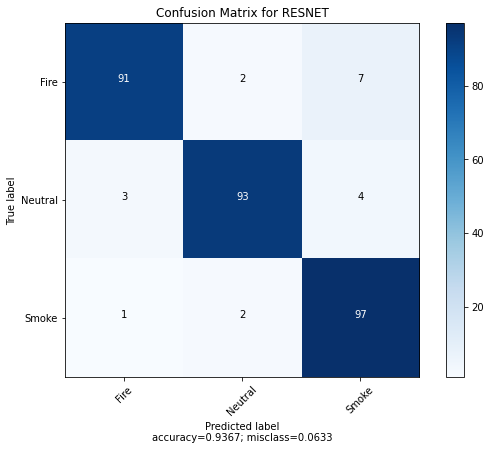

In [48]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for RESNET")

In [49]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
evalDict = {}
evalDict['Class Name'] = class_names
evalDict['Recall'] = recall
evalDict['Precision'] = precision
evalDf = pd.DataFrame(evalDict)
evalDf

,Class Name,Recall,Precision
0,Fire,0.91,0.957895
1,Neutral,0.93,0.958763
2,Smoke,0.97,0.898148


## 3. VGG-16

In [50]:
modelVGG = models.vgg16(pretrained=True)
for param in modelVGG.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [51]:
#Hyperparams
VGGLR = 0.001
VGGEPOCH = 10
VGGSEED = 42
VGGDROPOUT  = 0.5
torch.manual_seed(VGGSEED)
torch.cuda.manual_seed(VGGSEED)


#Modifying the classicification section 
modelVGG.classifier = nn.Sequential(nn.Linear(25088,4096),
                                    nn.ReLU(),
                                    nn.Dropout(VGGDROPOUT),
                                    nn.Linear(4096,1024),
                                    nn.ReLU(),
                                    nn.Dropout(VGGDROPOUT),
                                    nn.Linear(1024,512),
                                    nn.ReLU(),
                                    nn.Dropout(VGGDROPOUT),
                                    nn.Linear(512,256),
                                    nn.ReLU(),
                                    nn.Dropout(VGGDROPOUT),
                                    nn.Linear(256,64),
                                    nn.ReLU(),
                                    nn.Dropout(VGGDROPOUT),
                                    nn.Linear(64,3))
modelVGG = modelVGG.cuda()

In [52]:
total_params = 0
for parameters in modelVGG.parameters():
      total_params += parameters.numel()
print(f"Total params (vgg16): {total_params/1000000} mil")

Total params (vgg16): 122.347331 mil


In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelVGG.classifier.parameters(), lr=VGGLR,momentum=0.9)

In [54]:
modelVGG.train()
start_time = time.time()

# Tracking losses
train_losses_vgg = []
test_losses_vgg = []
train_correct_vgg = []
test_correct_vgg = []


for i in range(VGGEPOCH):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):


        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        b+=1
        y_pred = modelVGG(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing #correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%70 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
      
    train_losses_vgg.append(loss)
    train_correct_vgg.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelVGG(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses_vgg.append(loss)
    test_correct_vgg.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

Epoch:1 Batch:70 Loss:1.0936693 accuracy: 33.857% 
Epoch:1 Batch:140 Loss:1.0952690 accuracy: 34.357% 
Epoch:1 Batch:210 Loss:1.0902196 accuracy: 36.905% 
Epoch:2 Batch:70 Loss:1.0751965 accuracy: 43.429% 
Epoch:2 Batch:140 Loss:0.9485086 accuracy: 42.357% 
Epoch:2 Batch:210 Loss:0.8013111 accuracy: 43.905% 
Epoch:3 Batch:70 Loss:0.8230473 accuracy: 67.857% 
Epoch:3 Batch:140 Loss:0.8359331 accuracy: 67.286% 
Epoch:3 Batch:210 Loss:0.6712154 accuracy: 66.619% 
Epoch:4 Batch:70 Loss:0.3135770 accuracy: 72.857% 
Epoch:4 Batch:140 Loss:0.5246537 accuracy: 73.571% 
Epoch:4 Batch:210 Loss:0.3241215 accuracy: 75.762% 
Epoch:5 Batch:70 Loss:0.1333422 accuracy: 88.714% 
Epoch:5 Batch:140 Loss:0.2897981 accuracy: 90.286% 
Epoch:5 Batch:210 Loss:0.1445855 accuracy: 90.238% 
Epoch:6 Batch:70 Loss:0.0853538 accuracy: 95.714% 
Epoch:6 Batch:140 Loss:0.7460120 accuracy: 95.071% 
Epoch:6 Batch:210 Loss:0.0347189 accuracy: 94.810% 
Epoch:7 Batch:70 Loss:0.0206076 accuracy: 95.857% 
Epoch:7 Batch:140 L

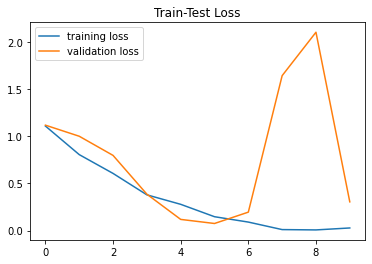

In [55]:
plt.plot(train_losses_vgg, label='training loss')
plt.plot(test_losses_vgg, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

In [ ]:
plt.plot([t/270 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch (VGG16)')
plt.legend();

In [56]:
for i,acc in enumerate(test_correct_vgg):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/len(test_data):.2f}%')

Test accuracy for ephoch-1: 43.00%
Test accuracy for ephoch-2: 61.00%
Test accuracy for ephoch-3: 65.33%
Test accuracy for ephoch-4: 76.00%
Test accuracy for ephoch-5: 89.00%
Test accuracy for ephoch-6: 89.33%
Test accuracy for ephoch-7: 89.67%
Test accuracy for ephoch-8: 91.33%
Test accuracy for ephoch-9: 91.33%
Test accuracy for ephoch-10: 91.67%


In [57]:
# Manual evaluation on test set
modelVGG.eval()
corr_pred = 0
act = []
pred = []

for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelVGG(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(class_names[labs[i].item()])
        pred.append(class_names[new_pred.item()])
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (VGG16): {corr_pred} ")
print(f"\nTest Set Accuracy (VGG16): {100*corr_pred/len(test_data):.2f}% ")



Correctly Predicted (VGG16): 280 

Test Set Accuracy (VGG16): 93.33% 


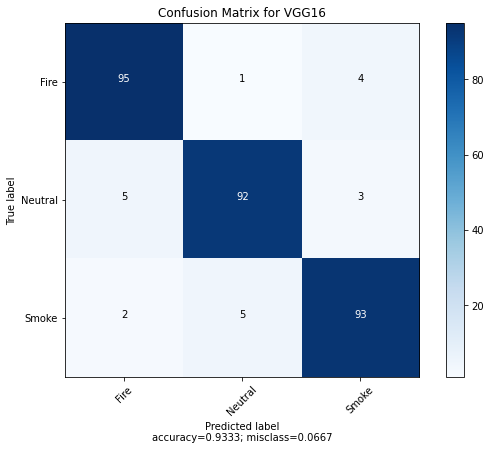

In [58]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for VGG16")

In [59]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
evalDict = {}
evalDict['Class Name'] = class_names
evalDict['Recall'] = recall
evalDict['Precision'] = precision
evalDf = pd.DataFrame(evalDict)
evalDf

,Class Name,Recall,Precision
0,Fire,0.95,0.931373
1,Neutral,0.92,0.938776
2,Smoke,0.93,0.930000


# 4. ZFNET

In [60]:
# ZFNet model
class ZFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, padding_mode='reflect') 
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2, padding_mode='reflect')
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.fc6 = nn.Linear(9216,4096)
        self.fc7 = nn.Linear(4096,4096)
        self.fc8 = nn.Linear(4096,3)
        self.pool1 = nn.MaxPool2d(3,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.drop = nn.Dropout(0.5)
        self.drop = nn.Dropout(0.5)
        self.lrn = nn.LocalResponseNorm(size=5,alpha=10e-4,beta=0.75,k=2.0)

    def forward(self, x):
        x = self.lrn(self.pool1(F.relu(self.conv1(x))))
        x = self.lrn(self.pool2(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(F.relu(self.conv5(x)))
        x = x.view(-1,9216)
        x = F.relu(self.drop(self.fc6(x)))
        x = F.relu(self.drop(self.fc7(x)))
        x = self.fc8(x)
        return x

In [61]:
modelZfnet = ZFNet()
modelZfnet = modelZfnet.cuda()

In [62]:
total_params = 0
for parameters in modelZfnet.parameters():
      total_params += parameters.numel()
print(f"Total params (ZFNet): {total_params/1000000} mil")

Total params (ZFNet): 58.272899 mil


In [63]:
#Hyperparams
ZFLR = 0.001
ZFEPOCH = 15
ZFSEED = 42
torch.manual_seed(ZFSEED)
torch.cuda.manual_seed(ZFSEED)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelZfnet.parameters(), lr=ZFLR,momentum=0.9)

In [64]:
modelZfnet.train()
start_time = time.time()

# Tracking losses
train_losses_zf = []
test_losses_zf = []
train_correct_zf = []
test_correct_zf = []


for i in range(ZFEPOCH):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        b+=1
        y_pred = modelZfnet(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing #correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%70 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
      
    train_losses_zf.append(loss)
    train_correct_zf.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelZfnet(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses_zf.append(loss)
    test_correct_zf.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

Epoch:1 Batch:70 Loss:1.1062340 accuracy: 34.714% 
Epoch:1 Batch:140 Loss:1.0973941 accuracy: 34.357% 
Epoch:1 Batch:210 Loss:1.0994226 accuracy: 33.714% 
Epoch:2 Batch:70 Loss:1.1035771 accuracy: 35.000% 
Epoch:2 Batch:140 Loss:1.0899091 accuracy: 37.429% 
Epoch:2 Batch:210 Loss:1.0900649 accuracy: 36.333% 
Epoch:3 Batch:70 Loss:1.0949570 accuracy: 54.286% 
Epoch:3 Batch:140 Loss:1.0797000 accuracy: 55.714% 
Epoch:3 Batch:210 Loss:1.0915780 accuracy: 56.714% 
Epoch:4 Batch:70 Loss:0.7110695 accuracy: 64.571% 
Epoch:4 Batch:140 Loss:0.7449062 accuracy: 64.571% 
Epoch:4 Batch:210 Loss:0.7204074 accuracy: 64.476% 
Epoch:5 Batch:70 Loss:1.1112745 accuracy: 67.571% 
Epoch:5 Batch:140 Loss:0.3553711 accuracy: 70.429% 
Epoch:5 Batch:210 Loss:0.4973329 accuracy: 72.571% 
Epoch:6 Batch:70 Loss:0.3699633 accuracy: 77.857% 
Epoch:6 Batch:140 Loss:0.4820407 accuracy: 78.357% 
Epoch:6 Batch:210 Loss:0.9356128 accuracy: 78.286% 
Epoch:7 Batch:70 Loss:0.6668811 accuracy: 82.143% 
Epoch:7 Batch:140 L

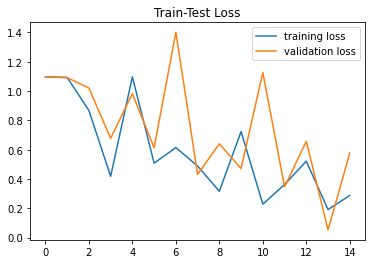

In [65]:
plt.plot(train_losses_zf, label='training loss')
plt.plot(test_losses_zf, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

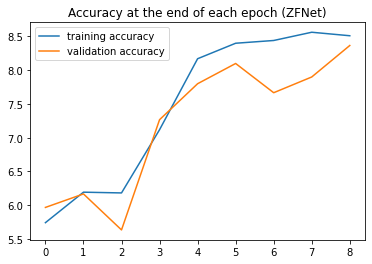

In [84]:
plt.plot([t/270 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch (ZFNet)')
plt.legend();

In [66]:
for i,acc in enumerate(test_correct_zf):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/len(test_data):.2f}%')

Test accuracy for ephoch-1: 42.00%
Test accuracy for ephoch-2: 51.33%
Test accuracy for ephoch-3: 54.67%
Test accuracy for ephoch-4: 66.67%
Test accuracy for ephoch-5: 72.00%
Test accuracy for ephoch-6: 77.67%
Test accuracy for ephoch-7: 76.67%
Test accuracy for ephoch-8: 78.33%
Test accuracy for ephoch-9: 78.67%
Test accuracy for ephoch-10: 75.67%
Test accuracy for ephoch-11: 78.00%
Test accuracy for ephoch-12: 80.33%
Test accuracy for ephoch-13: 77.67%
Test accuracy for ephoch-14: 79.67%
Test accuracy for ephoch-15: 79.33%


In [67]:
# Manual evaluation on test set
modelZfnet.eval()
corr_pred = 0
act = []
pred = []

for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelZfnet(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(class_names[labs[i].item()])
        pred.append(class_names[new_pred.item()])
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (ZFNET): {corr_pred} ")
print(f"\nTest Set Accuracy (ZFNET): {100*corr_pred/len(test_data):.2f}% ")



Correctly Predicted (ZFNET): 237 

Test Set Accuracy (ZFNET): 79.00% 


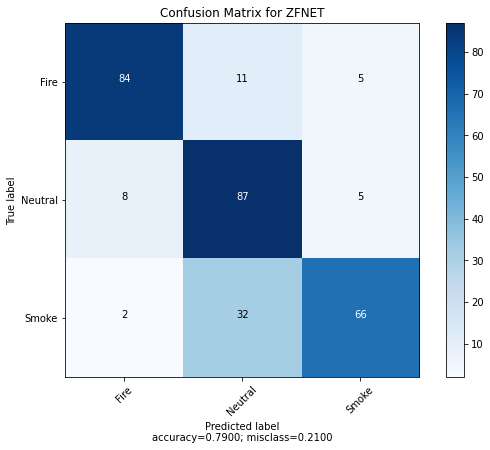

In [68]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for ZFNET")

In [69]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
evalDict = {}
evalDict['Class Name'] = class_names
evalDict['Recall'] = recall
evalDict['Precision'] = precision
evalDf = pd.DataFrame(evalDict)
evalDf

,Class Name,Recall,Precision
0,Fire,0.84,0.893617
1,Neutral,0.87,0.669231
2,Smoke,0.66,0.868421


# 5. GoogLeNet

In [70]:
modelGNET = models.googlenet(pretrained=True)
for param in modelGNET.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [71]:
total_params = 0
for parameters in modelGNET.parameters():
      total_params += parameters.numel()
print(f"Total params (GoogLeNet): {total_params/1000000} mil")

Total params (GoogLeNet): 6.624904 mil


In [72]:
#Modifying the FC layer
modelGNET.fc = nn.Linear(modelGNET.fc.in_features, len(class_names))
modelGNET = modelGNET.to(device)

In [73]:
#Hyper parameters
GNLR = 0.001
GNMomentum = 0.9
GNEPOCH = 15
GNSEED = 101

torch.manual_seed(GNSEED)
torch.cuda.manual_seed(GNSEED)

criterion = nn.CrossEntropyLoss()
#SGD as optimizer with lr and momentum
optimizer = torch.optim.SGD(modelGNET.fc.parameters(), lr= GNLR, momentum= GNMomentum)


In [74]:
modelGNET.train()

start_time = time.time()

# Tracking losses
train_losses_gn = []
test_losses_gn = []
train_correct_gn = []
test_correct_gn = []


for i in range(GNEPOCH):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
            
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        b+=1
        y_pred = modelGNET(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing #correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%70 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
    
    train_losses_gn.append(loss)
    train_correct_gn.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_test_pred = modelGNET(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses_gn.append(loss)
    test_correct_gn.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

Epoch:1 Batch:70 Loss:0.5533191 accuracy: 60.143% 
Epoch:1 Batch:140 Loss:0.4121051 accuracy: 69.857% 
Epoch:1 Batch:210 Loss:0.5182469 accuracy: 73.810% 
Epoch:2 Batch:70 Loss:0.3695650 accuracy: 83.429% 
Epoch:2 Batch:140 Loss:0.7257613 accuracy: 84.643% 
Epoch:2 Batch:210 Loss:0.3382156 accuracy: 84.905% 
Epoch:3 Batch:70 Loss:0.3646238 accuracy: 86.000% 
Epoch:3 Batch:140 Loss:0.3542871 accuracy: 86.571% 
Epoch:3 Batch:210 Loss:0.7922891 accuracy: 86.190% 
Epoch:4 Batch:70 Loss:0.3533995 accuracy: 86.571% 
Epoch:4 Batch:140 Loss:0.2893715 accuracy: 85.286% 
Epoch:4 Batch:210 Loss:0.2833545 accuracy: 84.619% 
Epoch:5 Batch:70 Loss:0.1168222 accuracy: 85.000% 
Epoch:5 Batch:140 Loss:0.4144368 accuracy: 85.857% 
Epoch:5 Batch:210 Loss:0.4477040 accuracy: 86.143% 
Epoch:6 Batch:70 Loss:0.1997193 accuracy: 86.714% 
Epoch:6 Batch:140 Loss:0.4536788 accuracy: 87.429% 
Epoch:6 Batch:210 Loss:0.4658490 accuracy: 86.429% 
Epoch:7 Batch:70 Loss:0.5931929 accuracy: 87.429% 
Epoch:7 Batch:140 L

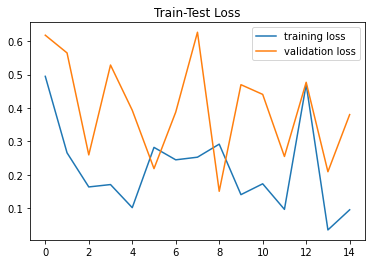

In [75]:
plt.plot(train_losses_gn, label='training loss')
plt.plot(test_losses_gn, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

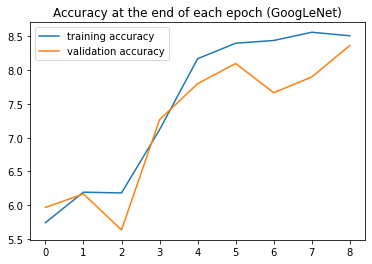

In [83]:
plt.plot([t/270 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch (GoogLeNet)')
plt.legend();

In [76]:
print(test_correct_gn)
test_data_size = len(test_data)
print(f'\nTest accuracy (max): {np.array(test_correct_gn).max().item()*100/test_data_size:.2f}%')

[tensor(251, device='cuda:0'), tensor(257, device='cuda:0'), tensor(264, device='cuda:0'), tensor(249, device='cuda:0'), tensor(254, device='cuda:0'), tensor(251, device='cuda:0'), tensor(260, device='cuda:0'), tensor(259, device='cuda:0'), tensor(268, device='cuda:0'), tensor(260, device='cuda:0'), tensor(260, device='cuda:0'), tensor(255, device='cuda:0'), tensor(254, device='cuda:0'), tensor(265, device='cuda:0'), tensor(262, device='cuda:0')]

Test accuracy (max): 89.33%


In [77]:
#Accuracy for each epoch
for i,acc in enumerate(test_correct_gn):
    print(f'Test accuracy for ephoch-{i+1}: {acc.item()*100/test_data_size:.2f}%')

Test accuracy for ephoch-1: 83.67%
Test accuracy for ephoch-2: 85.67%
Test accuracy for ephoch-3: 88.00%
Test accuracy for ephoch-4: 83.00%
Test accuracy for ephoch-5: 84.67%
Test accuracy for ephoch-6: 83.67%
Test accuracy for ephoch-7: 86.67%
Test accuracy for ephoch-8: 86.33%
Test accuracy for ephoch-9: 89.33%
Test accuracy for ephoch-10: 86.67%
Test accuracy for ephoch-11: 86.67%
Test accuracy for ephoch-12: 85.00%
Test accuracy for ephoch-13: 84.67%
Test accuracy for ephoch-14: 88.33%
Test accuracy for ephoch-15: 87.33%


In [78]:
# Manual evaluation on test set
modelGNET.eval()
corr_pred = 0
act = []
pred = []
for img_batch, labs in test_loader:
    for i,img in enumerate(img_batch):
        with torch.no_grad():
            new_pred = modelGNET(img.view(1,3,224,224).cuda()).argmax()
        
        #print(f'Predicted Class: {class_names[new_pred.item()]}  Actual Class: {class_names[labs[i].item()]}')
        act.append(labs[i].item())
        pred.append(new_pred.item())
        
        if class_names[new_pred.item()]==class_names[labs[i].item()]:
            corr_pred+=1
print(f"\nCorrectly Predicted (GoogLeNet): {corr_pred} ")
print(f"\nTest Set Accuracy (GoogLeNet): {100*corr_pred/len(test_data):.2f}% ")


Correctly Predicted (GoogLeNet): 273 

Test Set Accuracy (GoogLeNet): 91.00% 


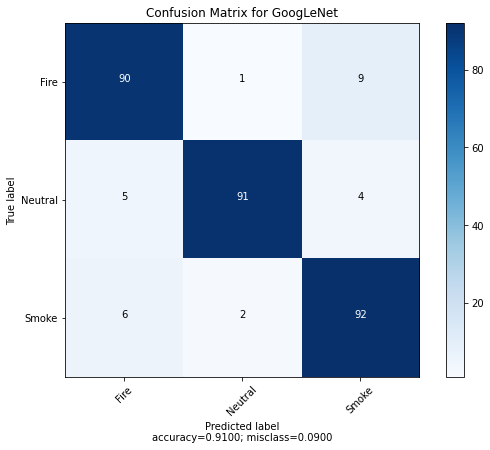

In [79]:
#Confusion Matrix
cm = confusion_matrix(act,pred)
plot_confusion_matrix(cm,normalize=False,target_names = class_names, title= "Confusion Matrix for GoogLeNet")

In [80]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
evalDict = {}
evalDict['Class Name'] = class_names
evalDict['Recall'] = recall
evalDict['Precision'] = precision
evalDf = pd.DataFrame(evalDict)
evalDf

,Class Name,Recall,Precision
0,Fire,0.90,0.891089
1,Neutral,0.91,0.968085
2,Smoke,0.92,0.876190
